In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os


In [2]:
# 1. Загрузка данных
path = r"D:\Эстер\с рс\Courses\ML Engineer\HWEster16\kaggle_archive"
train_df = pd.read_csv(os.path.join(path, "train.csv"))

def eda_statistics(df):
    """Функция для расчета основных статистик по данным."""
    stats = pd.DataFrame({
        'Missing Values': df.isnull().sum(),
        'Min': df.min(numeric_only=True),
        'Max': df.max(numeric_only=True),
        'Mean': df.mean(numeric_only=True),
        'Median': df.median(numeric_only=True),
        'Variance': df.var(numeric_only=True),
        '10% Quantile': df.quantile(0.1, numeric_only=True),
        '90% Quantile': df.quantile(0.9, numeric_only=True),
        '1st Quartile': df.quantile(0.25, numeric_only=True),
        '3rd Quartile': df.quantile(0.75, numeric_only=True)
    })
    return stats

In [3]:
# 2. Проведение EDA
eda_stats = eda_statistics(train_df)
print(eda_stats)


                      Missing Values         Min           Max           Mean  \
Age                            18705   18.000000  6.400000e+01      41.145563   
Annual Income                  44949    1.000000  1.499970e+05   32745.217777   
Credit Score                  137882  300.000000  8.490000e+02     592.924350   
Customer Feedback              77824         NaN           NaN            NaN   
Education Level                    0         NaN           NaN            NaN   
Exercise Frequency                 0         NaN           NaN            NaN   
Gender                             0         NaN           NaN            NaN   
Health Score                   74076    2.012237  5.897591e+01      25.613908   
Insurance Duration                 1    1.000000  9.000000e+00       5.018219   
Location                           0         NaN           NaN            NaN   
Marital Status                 18529         NaN           NaN            NaN   
Number of Dependents        

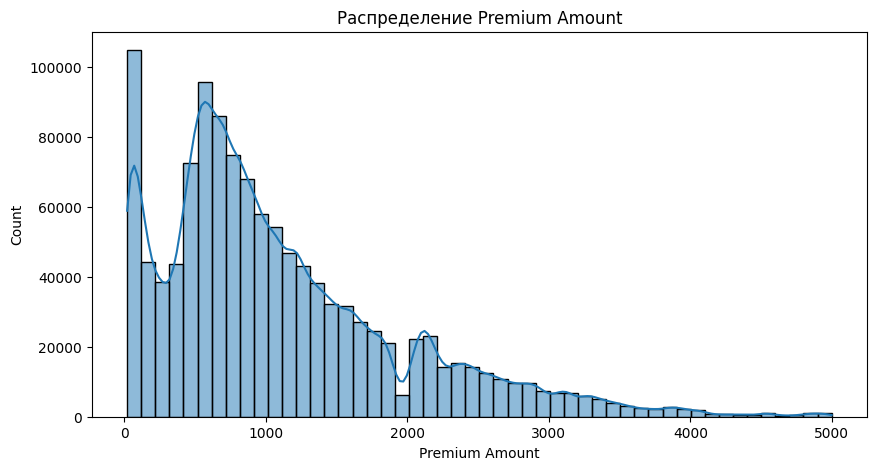

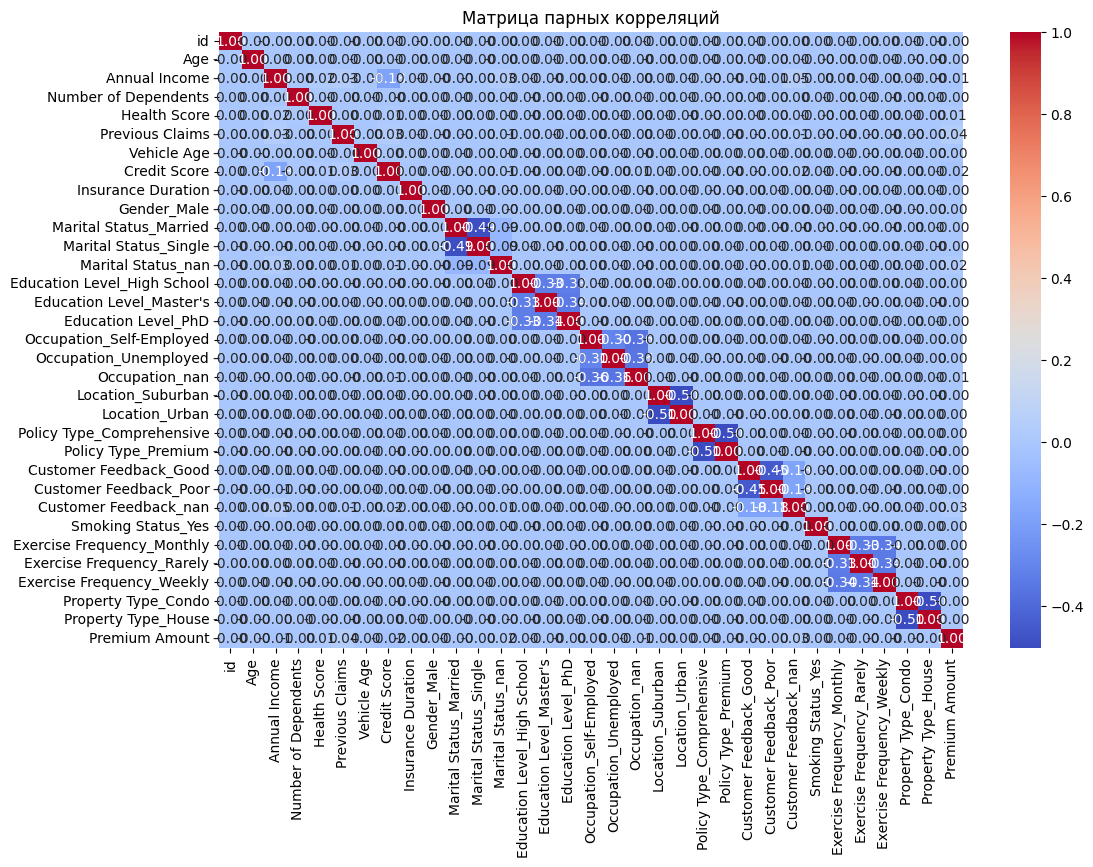

In [9]:
# 3. Подготовка данных
plt.figure(figsize=(10, 5))
sns.histplot(train_df['Premium Amount'], bins=50, kde=True)
plt.title('Распределение Premium Amount')
plt.show()

# Обработка пропусков
train_df.fillna(train_df.median(numeric_only=True), inplace=True)

# Обработка категориальных переменных
categorical_columns = ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
                        'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']
ohe = OneHotEncoder(drop='first', sparse_output=False)
categorical_data = ohe.fit_transform(train_df[categorical_columns])
categorical_df = pd.DataFrame(categorical_data, columns=ohe.get_feature_names_out(categorical_columns))

# Объединение с числовыми данными
numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns.remove('Premium Amount')
final_df = pd.concat([train_df[numerical_columns], categorical_df, train_df['Premium Amount']], axis=1)

# Масштабирование данных
scaler = StandardScaler()
scaled_features = scaler.fit_transform(final_df.drop(columns=['Premium Amount']))
X = pd.DataFrame(scaled_features, columns=final_df.drop(columns=['Premium Amount']).columns)
y = final_df['Premium Amount']

# Вычисление матрицы парных корреляций
plt.figure(figsize=(12, 8))
sns.heatmap(final_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Матрица парных корреляций")
plt.show()

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# 4. Обучение моделей с кросс-валидацией
models = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet()
}

results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "CV Mean R2": np.mean(scores),
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }

# Вывод результатов
for model, metrics in results.items():
    print(f"{model} Results:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print()

Ridge Results:
CV Mean R2: 0.0037
MAE: 666.8934
MSE: 744588.7197
RMSE: 862.8955
R2: 0.0036

Lasso Results:
CV Mean R2: 0.0038
MAE: 666.9230
MSE: 744581.3409
RMSE: 862.8913
R2: 0.0036

ElasticNet Results:
CV Mean R2: 0.0032
MAE: 667.2603
MSE: 744943.2867
RMSE: 863.1010
R2: 0.0031



In [13]:
# 5. Подбор гиперпараметров
param_grid = {'alpha': np.logspace(-3, 3, 7)}

def tune_model(model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

best_ridge = tune_model(Ridge(), param_grid)
best_lasso = tune_model(Lasso(), param_grid)
best_elasticnet = tune_model(ElasticNet(), param_grid)

In [14]:
# Оценка лучших моделей
best_models = {
    "Best Ridge": best_ridge,
    "Best Lasso": best_lasso,
    "Best ElasticNet": best_elasticnet
}

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"{name} Results:")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
    print(f"R2: {r2_score(y_test, y_pred):.4f}\n")

Best Ridge Results:
MAE: 666.8941
MSE: 744588.6976
RMSE: 862.8955
R2: 0.0036

Best Lasso Results:
MAE: 666.9230
MSE: 744581.3409
RMSE: 862.8913
R2: 0.0036

Best ElasticNet Results:
MAE: 666.8969
MSE: 744588.4801
RMSE: 862.8954
R2: 0.0036

